import needed library and declare list of category column

In [41]:

import csv
import pandas as pd
import numpy as np
import random
import nltk
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize
from collections import defaultdict
from nltk.probability import FreqDist
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.tag import pos_tag

crawledDataSetNames = ['dataset-reddit-business.csv', 'dataset-reddit-entertainment.csv', 
'dataset-reddit-parenting.csv', 'dataset-reddit-politics.csv', 
'dataset-reddit-sports.csv', 'dataset-reddit-travel.csv']

categories = ['business', 'entertainment', 'parenting', 'politics', 'sports', 'travel']




preprocessing function

In [42]:
def preprocessing(originData):
    data = originData.copy()
    #make all characters to lower case
    data['text']=data['text'].apply(lambda x: str.lower(x))

    #word tokenization and pos tagging
    data['text'] = data['text'].apply(lambda x: pos_tag(wordpunct_tokenize(x)))

    #delete non alphabets word and stopwords
    engStopwords =set(stopwords.words('english'))
    data['text'] = data['text'].apply(lambda x: 
        list((word, pos) for (word, pos) in x if word.isalpha() and 
            word not in engStopwords))
    
    #lemmatization
    wnl = WordNetLemmatizer()
    posListForLemmatization =list('NVJR')
    changePosFirstCharForLemmatization = lambda c: str.lower(c) if c!= 'J' else 'a'
    data['text'] = data['text'].apply(lambda x: 
            list( wnl.lemmatize(word, changePosFirstCharForLemmatization(pos[0])) 
                if pos[0] in posListForLemmatization else word for (word, pos) in x))

    print('preprocessing finished. 1 / 6')
    return data

declare making word dictionary function and making Bag Of words Column function.

In [43]:
def makingWordDict(originData):
    data = originData.copy()
    listedText=data['text'].tolist()
    allTextList = []
    for l in listedText:
        allTextList.extend(l)
    numOfdict = len(set(allTextList))
    
    numOfFeatureWords = int(numOfdict*1)

    fdist = FreqDist(allTextList)

    wordDict = list(word for word, freq in fdist.most_common(numOfFeatureWords))

    print('making word dictionary finished. 2 / 6')
    return wordDict

def makingBagOfWordsCol(originData, wordDict):
    data = originData.copy()
    def bagOfWords(tokens):
        d = defaultdict(int,{ word:0 for word in wordDict })

        for token in tokens:
            d[token]+=1

        return list(d.values())[:len(wordDict)]

    data['bagOfWords'] = data['text'].apply(lambda x: bagOfWords(x))

    print('making bag of words column finished. 3 / 6')
    return data

declare divide trainset and testset function.

In [44]:
def divideTrainAndTest(originData):
    data = originData.copy()
    dataSize = data.shape[0]

    trainSplit = 0.7
    testSplit = 0.3

    trainSize = int(dataSize * trainSplit)
    testSize = int(dataSize * testSplit)

    print('trainSize: ', trainSize)
    print('testSize: ', testSize)

    trainSet = data.iloc[:trainSize, :]
    testSet = data.iloc[trainSize:, :]

    print('dividing train and test set finished. 4 / 6')
    return trainSet, testSet

declare build a Bag of Words model and fit by using train set.

In [45]:
def buildAndFitModel(trainSet):
    classifier = MultinomialNB()
    trainX = np.array(trainSet['bagOfWords'].tolist())
    trainY = np.array(trainSet['category'].tolist())
    
    classifier.fit(trainX, trainY)

    print('building and fitting the model finished. 5 / 6')
    return classifier

declare evaluate function.

In [46]:
def evaluate(classifier, testSet):
    testX = np.array(testSet['bagOfWords'].tolist())
    testY = np.array(testSet['category'].tolist())
    
    predY = classifier.predict(testX)
    predYProb = classifier.predict_proba(testX)
    evalTable = classification_report(testY, predY)
    print('evaluating the model finished. 6 / 6')
    print('-confusion matrix-\n')
    cm = confusion_matrix(testY, predY, labels=categories)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
    disp.plot()
    plt.show()
    return evalTable, predYProb

1. read the crawled Dataset of reddit.

In [47]:
rawRedditDataset = pd.DataFrame(columns = {'text','category'})
for crawledDataSetName in crawledDataSetNames:
    #read csv files
    df = pd.read_csv('./dataset/%s'%crawledDataSetName)
    
    #replace Nan to empty string
    df = df.fillna('')

    #'titleAndContent' Column is concat of 'title' and 'content'
    df['text']=df['title']+' '+df['content']
    rawRedditDataset = pd.concat([rawRedditDataset, df[['text', 'category']]])

rawRedditDataset=rawRedditDataset[['text', 'category']]
#shuffle row
rawRedditDataset=rawRedditDataset.sample(frac=1).reset_index(drop=True)

print(rawRedditDataset)

                                                   text       category
0     SAHD who likes to relax during personal time. ...      parenting
1     Ronda, Spain. These photos were taken on 2018,...         travel
2     Rome appreciation post- After the response on ...         travel
3                          All Futurama Opening Quotes   entertainment
4     Tennis chief says new video of Peng Shuai 'ins...         sports
...                                                 ...            ...
5936  Elton John scores first UK No 1 single in 16 y...  entertainment
5937  The Supreme Court Is Ready to Make Taxpayers F...       politics
5938  [crosspost] I'm Muggsy Bogues, former Starting...         sports
5939  Fox News host Tucker Carlson tells interviewer...  entertainment
5940  Cezary Kulesza, President of the Polish Footba...         sports

[5941 rows x 2 columns]


2. read the news category dataset(from kaggle).

In [48]:
originNewsCategory = ['BUSINESS', 'ENTERTAINMENT', 'PARENTING', 'POLITICS', 'SPORTS', 'TRAVEL']

rawNewsDataset = pd.read_json("./dataset/News_category_Dataset_v2.json", lines=True)
rawNewsDataset = rawNewsDataset[rawNewsDataset['category'].isin(originNewsCategory)]
rawNewsDataset = rawNewsDataset.groupby('category').sample(n=2000)
rawNewsDataset['category'] = rawNewsDataset['category'].apply(lambda x: x.lower())

rawNewsDataset['text'] = rawNewsDataset['headline'] + ' ' + rawNewsDataset['short_description']
rawNewsDataset = rawNewsDataset[['text','category']]

#shuffle row
rawNewsDataset=rawNewsDataset.sample(frac=1).reset_index(drop=True)

print(rawNewsDataset)

                                                    text       category
0      Starbucks To Stop Throwing Out Perfectly Good ...       business
1      Expat Recovery Room: TV's Sexy Travel Hosts Ri...         travel
2      'Magna Carta Holy Grail' Reviews: What The Cri...  entertainment
3      Trump Says Muslim Judges Also Might Not Be Fai...       politics
4      Detour to Chernobyl: Adventures in Mongol Rall...         travel
...                                                  ...            ...
11995  The Secrets of Publishing Success When I start...       business
11996  Am I Not Also My Sister's Keeper? The recent a...       politics
11997  Here's Actual Evidence That Racial Fear Benefi...       politics
11998  This Is Why Lifeguards Are Patrolling The Olym...         sports
11999  HUFFPOST HILL - RNC Gavels Into Session; Ohio ...       politics

[12000 rows x 2 columns]


3. the model only using reddit crawled dataset.

preprocessing finished. 1 / 6
making word dictionary finished. 2 / 6
making bag of words column finished. 3 / 6
trainSize:  4158
testSize:  1782
dividing train and test set finished. 4 / 6
building and fitting the model finished. 5 / 6
evaluating the model finished. 6 / 6
-confusion matrix-



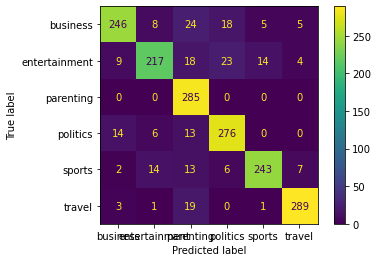

only reddit dataset model classification report
                precision    recall  f1-score   support

     business       0.90      0.80      0.85       306
entertainment       0.88      0.76      0.82       285
    parenting       0.77      1.00      0.87       285
     politics       0.85      0.89      0.87       309
       sports       0.92      0.85      0.89       285
       travel       0.95      0.92      0.94       313

     accuracy                           0.87      1783
    macro avg       0.88      0.87      0.87      1783
 weighted avg       0.88      0.87      0.87      1783



In [49]:
redditDataset = preprocessing(rawRedditDataset)
redditWordDict = makingWordDict(redditDataset)
BOWredditDataset = makingBagOfWordsCol(redditDataset, redditWordDict)

redditTrainSet, redditTestSet = divideTrainAndTest(BOWredditDataset)

redditClassifier = buildAndFitModel(redditTrainSet)

redditEvalTable, redditPredYProb = evaluate(redditClassifier, redditTestSet)

print('only reddit dataset model classification report\n', redditEvalTable)

4. the model only using news dataset.

preprocessing finished. 1 / 6
making word dictionary finished. 2 / 6
making bag of words column finished. 3 / 6
trainSize:  8400
testSize:  3600
dividing train and test set finished. 4 / 6
building and fitting the model finished. 5 / 6
evaluating the model finished. 6 / 6
-confusion matrix-



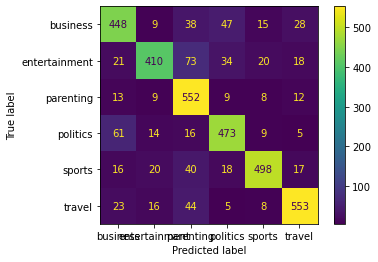

only news dataset model classification report
                precision    recall  f1-score   support

     business       0.77      0.77      0.77       585
entertainment       0.86      0.71      0.78       576
    parenting       0.72      0.92      0.81       603
     politics       0.81      0.82      0.81       578
       sports       0.89      0.82      0.85       609
       travel       0.87      0.85      0.86       649

     accuracy                           0.81      3600
    macro avg       0.82      0.81      0.81      3600
 weighted avg       0.82      0.81      0.82      3600



In [50]:
newsDataset = preprocessing(rawNewsDataset)
newsWordDict = makingWordDict(newsDataset)
BOWnewsDataset = makingBagOfWordsCol(newsDataset, newsWordDict)

newsTrainSet, newsTestSet = divideTrainAndTest(BOWnewsDataset)

newsClassifier = buildAndFitModel(newsTrainSet)

newsEvalTable, newsPredYProb = evaluate(newsClassifier, newsTestSet)

print('only news dataset model classification report\n', newsEvalTable)

5. the model using both reddit and news datasets.

preprocessing finished. 1 / 6
making word dictionary finished. 2 / 6
making bag of words column finished. 3 / 6
trainSize:  12558
testSize:  5382
dividing train and test set finished. 4 / 6
building and fitting the model finished. 5 / 6
evaluating the model finished. 6 / 6
-confusion matrix-



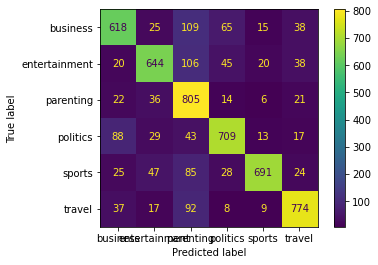

using both reddit and both dataset model classification report
                precision    recall  f1-score   support

     business       0.76      0.71      0.74       870
entertainment       0.81      0.74      0.77       873
    parenting       0.65      0.89      0.75       904
     politics       0.82      0.79      0.80       899
       sports       0.92      0.77      0.84       900
       travel       0.85      0.83      0.84       937

     accuracy                           0.79      5383
    macro avg       0.80      0.79      0.79      5383
 weighted avg       0.80      0.79      0.79      5383



In [51]:
rawBothDataset = pd.concat([rawRedditDataset, rawNewsDataset])

bothDataset = preprocessing(rawBothDataset)
bothWordDict = makingWordDict(bothDataset)
BOWbothDataset = makingBagOfWordsCol(bothDataset, bothWordDict)

bothTrainSet, bothTestSet = divideTrainAndTest(BOWbothDataset)

bothClassifier = buildAndFitModel(bothTrainSet)

bothAccuracy, bothPredYProb = evaluate(bothClassifier, bothTestSet)

print('using both reddit and both dataset model classification report\n', bothAccuracy)

6. predict category of reddit testset by the model only trained by news train set.

making bag of words column finished. 3 / 6
evaluating the model finished. 6 / 6
-confusion matrix-



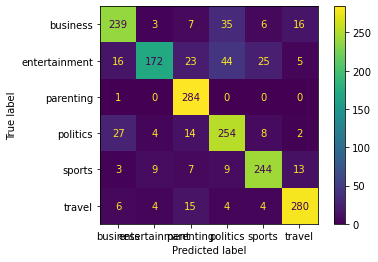

predicting the category of reddit test set on news-trained model classification report
                precision    recall  f1-score   support

     business       0.82      0.78      0.80       306
entertainment       0.90      0.60      0.72       285
    parenting       0.81      1.00      0.89       285
     politics       0.73      0.82      0.78       309
       sports       0.85      0.86      0.85       285
       travel       0.89      0.89      0.89       313

     accuracy                           0.83      1783
    macro avg       0.83      0.83      0.82      1783
 weighted avg       0.83      0.83      0.82      1783



In [52]:
BOWredditTestsetUsingNewsWordDict = makingBagOfWordsCol(redditTestSet, newsWordDict)

redditOnNewsEvalTable, redditOnNewsPredYProb = evaluate(newsClassifier, BOWredditTestsetUsingNewsWordDict)

print('predicting the category of reddit test set on news-trained model classification report\n', redditOnNewsEvalTable)


7. predict category of news testset by the model only trained by reddit train set.

making bag of words column finished. 3 / 6
evaluating the model finished. 6 / 6
-confusion matrix-



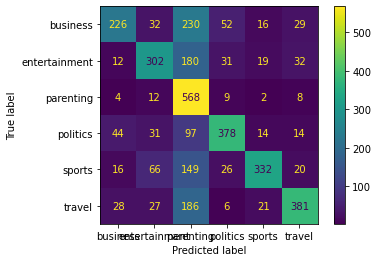

predicting the category of reddit test set on news-trained model classification report
                precision    recall  f1-score   support

     business       0.68      0.39      0.49       585
entertainment       0.64      0.52      0.58       576
    parenting       0.40      0.94      0.56       603
     politics       0.75      0.65      0.70       578
       sports       0.82      0.55      0.66       609
       travel       0.79      0.59      0.67       649

     accuracy                           0.61      3600
    macro avg       0.68      0.61      0.61      3600
 weighted avg       0.68      0.61      0.61      3600



In [53]:
BOWnewsTestsetUsingRedditWordDict = makingBagOfWordsCol(newsTestSet, redditWordDict)

newsOnRedditEvalTable, newsOnRedditPredYProb = evaluate(redditClassifier, BOWnewsTestsetUsingRedditWordDict)

print('predicting the category of reddit test set on news-trained model classification report\n', newsOnRedditEvalTable)
